In [337]:
import numpy as np
from scipy.stats import norm, multivariate_normal

import matplotlib.pyplot as plt

from utils import traceplot, acfplot

# Hybrid Rosenbrock


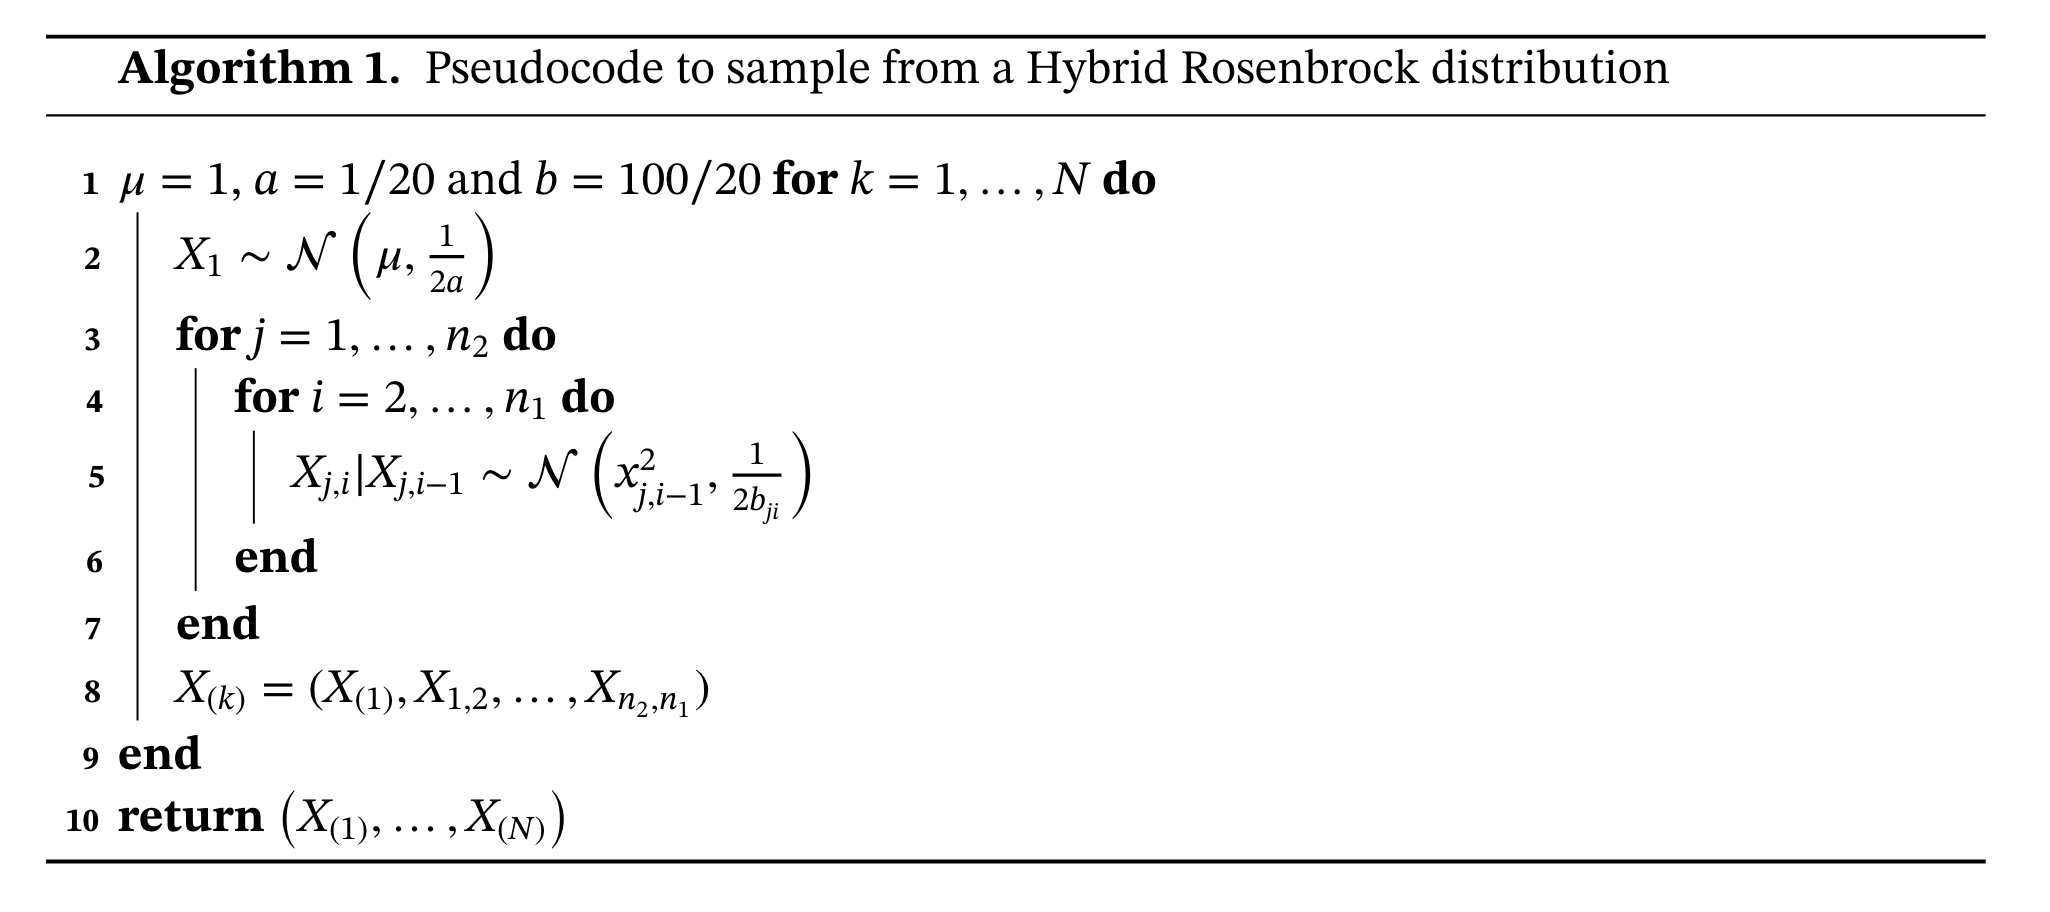


In [338]:
n1 = 3  # block size
n2 = 2  # number of blocks

for j in range(n2):
    for i in range(1, n1):
        print(i, j, (n1-1) * j + i)

1 0 1
2 0 2
1 1 3
2 1 4


In [339]:
def sample_rosenbrock(n_iter, n1, n2, mu=1, a=0.05, b=5):
    n_dim = (n1 - 1) * n2 + 1

    X = np.empty((n_dim, n_iter))

    for t in range(n_iter):
        X[0, t] = np.random.normal(mu, 1/np.sqrt(2*a))

        for j in range(n2):
            for i in range(1, n1):
                idx = (n1-1) * j + i

                if i == 1:
                    x_parent = X[0, t]
                else:
                    x_parent = X[idx-1, t]

                X[idx, t] = np.random.normal(x_parent**2, 1/np.sqrt(2*b))
    
    return X

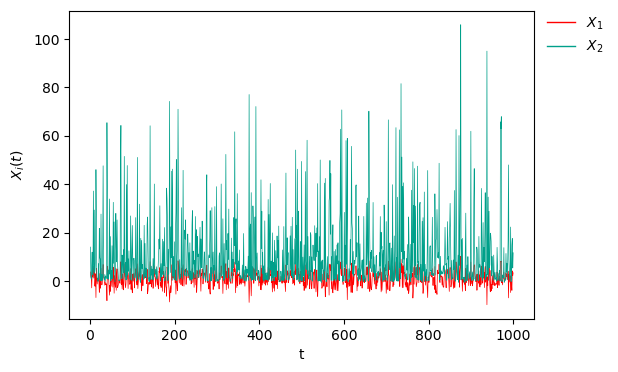

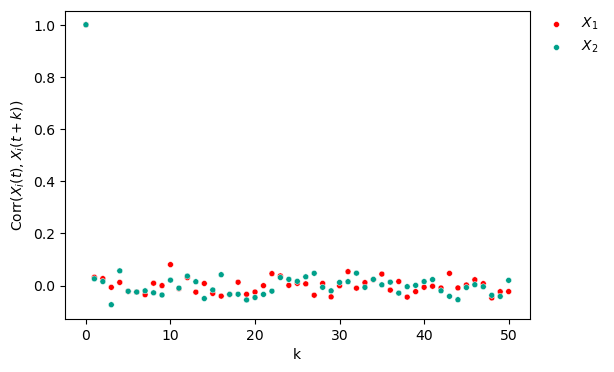

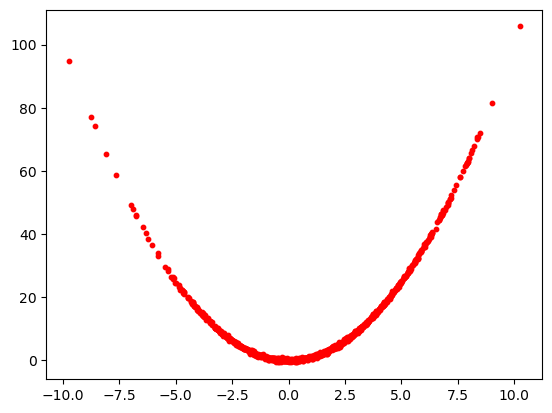

In [340]:
X_true = sample_rosenbrock(n_iter=1000, n1=2, n2=1)
traceplot(X_true)
acfplot(X_true)
plt.scatter(X_true[0, :], X_true[1, :], s=10)

## Hybrid Rosenbrock Kernel

$$\pi(\mathbf{x}) \propto \exp \left\{ -a\left(x_1 - \mu\right)^2 - b_{1, 2}\left(x_{1, 2} - x_1^2\right)^2 \right\}$$

Standard parametrization:

-   $\mu = 1$
-   $a  = 1/20$
-   $b_{i, j} = 100/20 \quad (\forall i, j)$


$$\log\pi(\mathbf{x}) \propto - a \left(x_1 - \mu\right)^2 - b_{1, 2} \left(x_{1, 2} - x_1^2\right)^2$$


In [341]:
def logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    logpi = - a * (x[0] - mu)**2

    for j in range(n2):
        for i in range(1, n1):
            idx = (n1-1) * j + i

            if i == 1:
                x_parent = x[0]
            else:
                x_parent = x[idx-1]
            
            logpi += - b * (x[idx] - x_parent**2)**2

    return logpi

$$
\frac{\partial}{\partial x_{j,i}}\log\pi(\mathbf{x})
=
\begin{cases}
-\,2\,a\,\bigl(x_1 - \mu\bigr)
  \;+\;\sum_{j=1}^{n_2} 4\,b_{j,2}\,\bigl(x_{j,2} - x_1^2\bigr)\,x_1
& \quad i = 1
\\[1.2em]
-2\,b_{j,i}\,\bigl(x_{j,i} - x_{j,i-1}^{2}\bigr)
   \;+\;
   4\,b_{j,i+1}\,\bigl(x_{j,i+1} - x_{j,i}^{2}\bigr)\,x_{j,i}
& \quad 2 \le i < n_1
\\[1.2em]
-2\,b_{j,n_{1}}\,
   \bigl(x_{j,n_{1}} - x_{j,n_{1}-1}^{2}\bigr)
& \quad i = n_1
\end{cases}
\quad
\text{for all } j = 1,\dots,n_{2}
$$


In [342]:
def partial_logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    partial_logpi = np.empty_like(x)

    partial_logpi[0] = - 2 * a * (x[0] - mu)
    for j in range(n2):
        partial_logpi[0] += 4 * b * (x[(n1-1)*j+1] - x[0]**2) * x[0]

    for j in range(n2):
        for i in range(1, n1-1):
            idx = (n1-1) * j + i

            if i == 1:
                x_parent = x[0]
            else:
                x_parent = x[idx-1]
            
            x_child = x[idx+1]

            partial_logpi[idx] = - 2 * b * (x[idx] - x_parent**2) + 4 * b * (x_child - x[idx]**2) * x[idx]
        
        # i = n1
        idx = (n1-1) * (j+1)  # (n1-1) * j + (n1-1)
        partial_logpi[idx] = - 2 * b * (x[idx] - x[idx-1]**2)
    
    return partial_logpi

$$
\begin{aligned}
%------------------------------------------------
% Second derivative wrt x_{j,i}^2
%------------------------------------------------
\frac{\partial^2}{\partial x_{j, i}^2}\,\log\pi(\mathbf{x})
&=
\begin{cases}
-\,2\,a
  \;+\;
  \displaystyle
  \sum_{j=1}^{n_{2}}
    4\,b_{j,2}\
      \Bigl(
         x_{j,2} \;-\; 3\,x_1^{2}
      \Bigr)
& \quad i = 1
\\[1.2em]
-\,2\,b_{j,i}
  \;+\;
  4\,b_{j,i+1}\
    \Bigl(
       x_{j,i+1} \;-\; 3\,x_{j,i}^{2}
    \Bigr)
& \quad 2 \le i < n_1
\\[1.2em]
-\,2\,b_{j,n_1}
& \quad i = n_1
\end{cases}
\\[1.2em]
%------------------------------------------------
% Cross partial derivative wrt x_{j,i} and x_{j,i'}
%------------------------------------------------
\frac{\partial^2}{\partial x_{j, i}\,\partial x_{j, i'}}\,\log\pi(\mathbf{x})
&=
\begin{cases}
4\,b_{j,i'}\,x_{j,i}
& \quad i' = i + 1
\\[1.2em]
0
& \quad \text{otherwise}
\end{cases}
\end{aligned}
$$


In [343]:
def hessian_logpi_rosenbrock(x, n1, n2, mu=1, a=0.05, b=5):
    hessian_logpi = np.zeros((x.shape[0], x.shape[0]))

    hessian_logpi[0, 0] = - 2 * a
    for j in range(n2):
        hessian_logpi[0, 0] += 4 * b * (x[(n1-1)*j+1] - 3*(x[0]**2))
    
    for j in range(n2):
        for i in range(1, n1-1):
            idx = (n1-1) * j + i
            hessian_logpi[idx, idx] = - 2 * b + 4 * b * (x[idx+1] - 3*(x[idx]**2))
        
        idx = (n1-1) * (j+1)
        hessian_logpi[idx, idx] = - 2 * b
    
    for j in range(n2):
        for i in range(1, n1):
            idx = (n1-1) * j + i
            
            if i == 1:
                hessian_logpi[idx, 0] = 4 * b * x[0]
                hessian_logpi[0, idx] = hessian_logpi[idx, 0]
            else:
                hessian_logpi[idx, idx-1] = 4 * b * x[idx-1]
                hessian_logpi[idx-1, idx] = hessian_logpi[idx, idx-1]
    
    return hessian_logpi

hessian_logpi_rosenbrock(np.asarray([0, 0]), n1=2, n2=1)

array([[ -0.1,   0. ],
       [  0. , -10. ]])

# MCMC


## RWM


In [344]:
def RWM_proposal(x, step_size):
    return x + step_size * np.random.normal(size=x.shape[0])


def RWM(logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        # Proposal state
        y = RWM_proposal(x, step_size)

        logpi_y = logpi(y, **kwargs)

        # Log RWM acceptance rate
        log_acceptance = logpi_y - logpi_x

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x

    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

Acceptance rate: 0.312


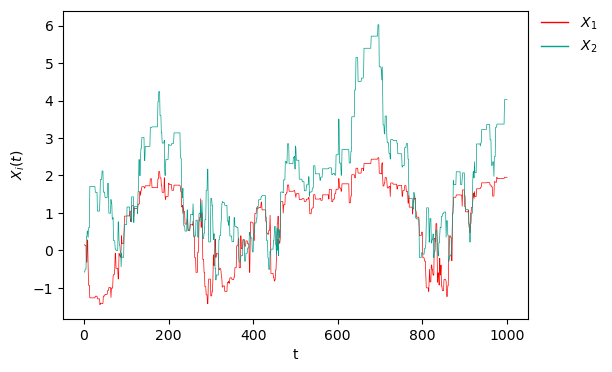

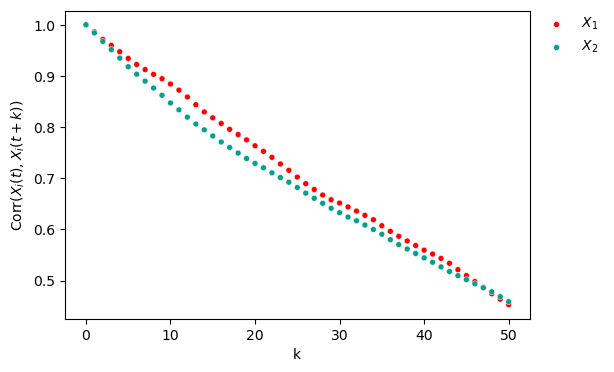

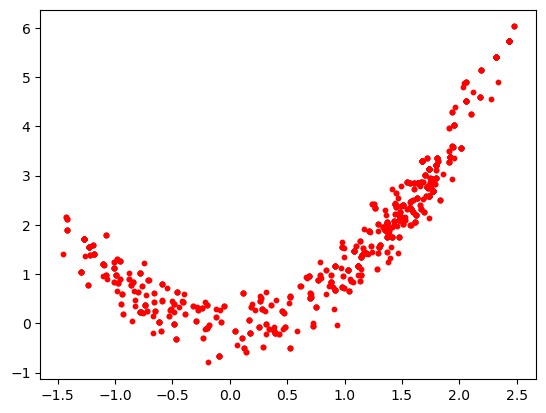

In [345]:
X_rwm, accept_rate = RWM(
    logpi=logpi_rosenbrock,
    n_iter=1000,
    x_init=[0, 0],
    step_size=0.5,
    n1=2,
    n2=1
)

print(f'Acceptance rate: {accept_rate}')
traceplot(X_rwm)
acfplot(X_rwm)
plt.scatter(X_rwm[0, :], X_rwm[1, :], s=10)

## MALA


In [346]:
def MALA_proposal(x, partial_logpi_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0])

    return x + (1/2) * (step_size**2) * partial_logpi_x + z


def MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size):
    log_xy = multivariate_normal.logpdf(y, mean=(x + (1/2) * (step_size**2) * partial_logpi_x), cov=(step_size**2))
    log_yx = multivariate_normal.logpdf(x, mean=(y + (1/2) * (step_size**2) * partial_logpi_y), cov=(step_size**2))
    
    return log_yx - log_xy


def MALA(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        
        # Proposal state
        y = MALA_proposal(x, partial_logpi_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log preconditioned MALA acceptance rate
        log_acceptance = logpi_y - logpi_x + MALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate

Acceptance rate: 0.16


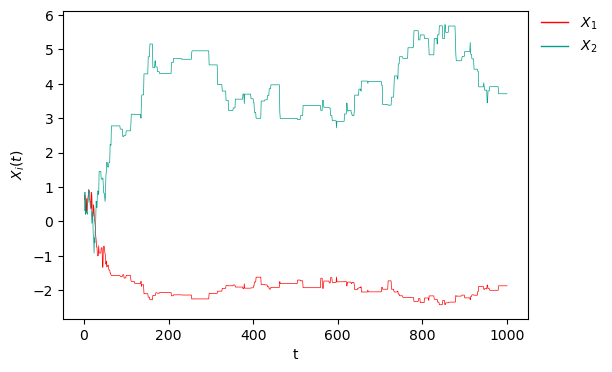

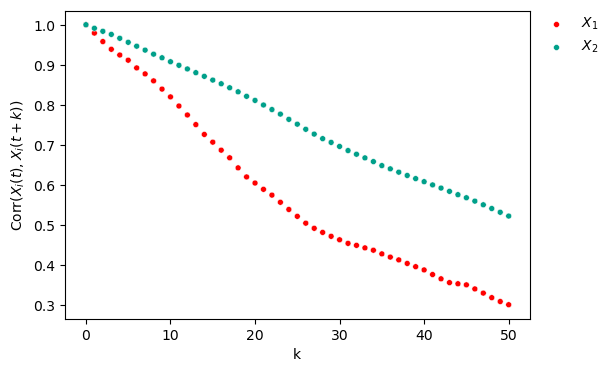

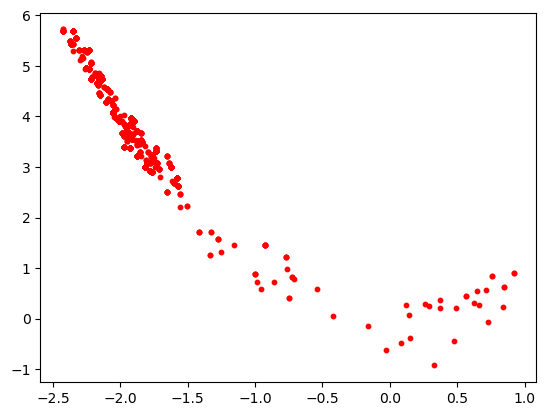

In [347]:
X_mala, accept_rate = MALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    n_iter=1000,
    x_init=[0, 0],
    step_size=0.3,
    n1=2,
    n2=1
)

print(f'Acceptance rate: {accept_rate}')
traceplot(X_mala)
acfplot(X_mala)
plt.scatter(X_mala[0, :], X_mala[1, :], s=10)

## Barker


In [348]:
def Barker_proposal(x, partial_logpi_x, step_size=1):
    # Magnitude
    z = step_size * np.random.normal(size=len(x), scale=1)

    # Direction
    threshold = 1 / (1 + np.exp(- z * partial_logpi_x))
    b = np.where(np.random.uniform(size=1) < threshold, 1, -1) 

    return x + b * z


def Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y):
    z = y - x

    logq_xy = - np.log1p(np.exp(- z * partial_logpi_x))
    logq_yx = - np.log1p(np.exp(z * partial_logpi_y))

    return np.sum(logq_yx - logq_xy)
   

def Barker(logpi, partial_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)
    
    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)

        # Proposal state
        y = Barker_proposal(x, partial_logpi_x, step_size)

        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)

        # Log Barker acceptance rate
        log_acceptance = logpi_y - logpi_x + Barker_logq_ratio(x, y, partial_logpi_x, partial_logpi_y)
        
        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted +=1

        X[:, i] = x
    
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate 

Acceptance rate: 0.647


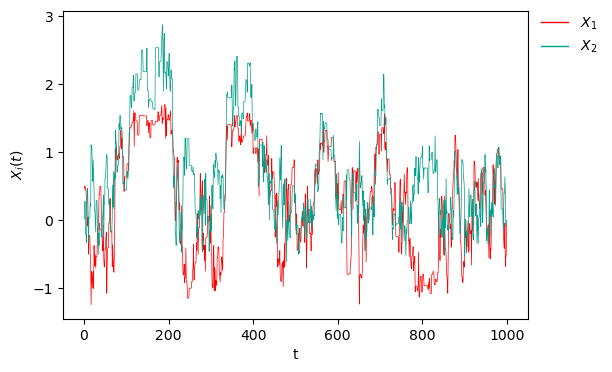

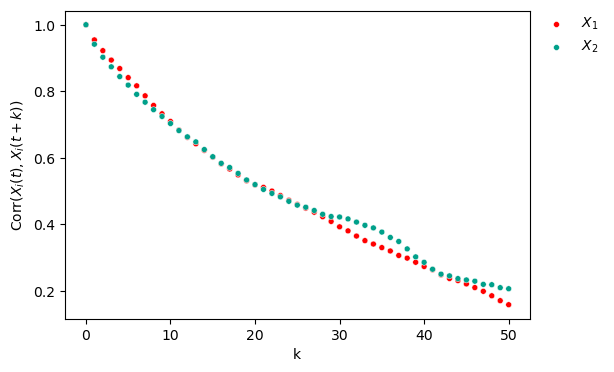

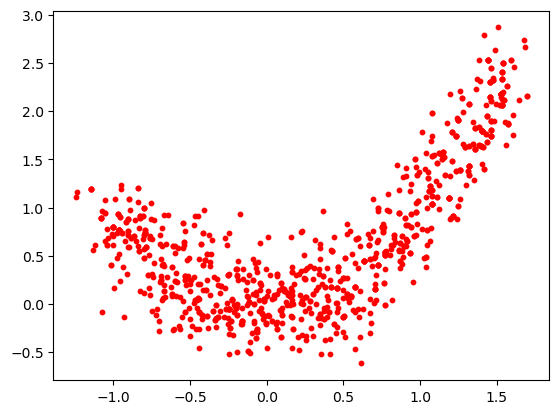

In [349]:
X_barker, accept_rate = Barker(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    n_iter=1000,
    x_init=[0, 0],
    step_size=0.4,
    n1=2,
    n2=1
)

print(f'Acceptance rate: {accept_rate}')
traceplot(X_barker)
acfplot(X_barker)
plt.scatter(X_barker[0, :], X_barker[1, :], s=10)

## SMMALA


Acceptance rate: 0.603


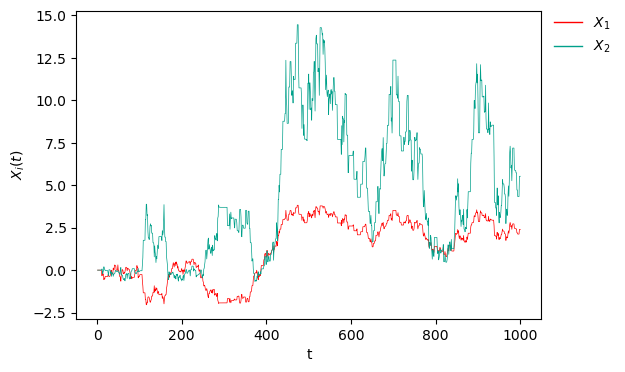

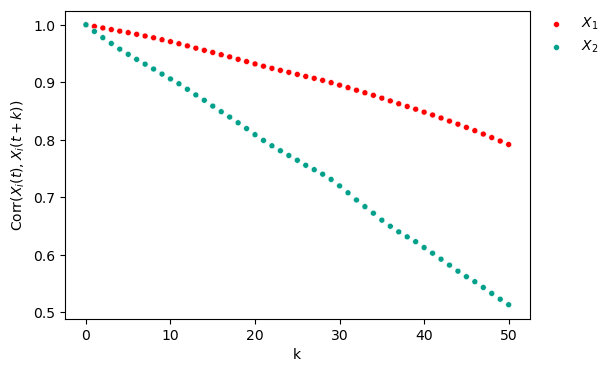

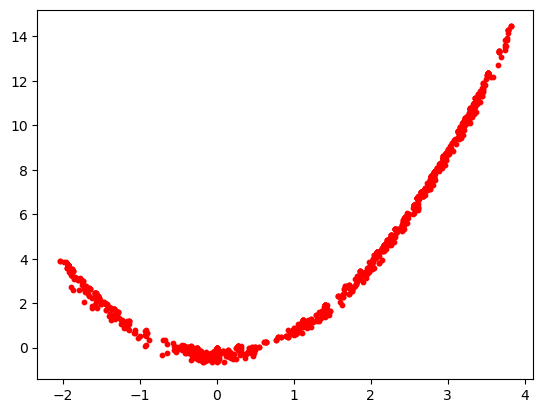

In [376]:
def project_to_psd(A):
    '''
    Project a matrix to the positive semidefinite cone.
    '''
    eigenvalues, eigenvectors = np.linalg.eigh(A)

    # Set negative eigenvalues to 1e-10 for numerical stability
    eigenvalues = np.maximum(eigenvalues, 1e-10)

    # Reconstruct the matrix
    A_psd = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T

    return A_psd


def SMMALA_proposal(x, partial_logpi_x, A_x, step_size):
    z = step_size * np.random.normal(size=x.shape[0]) 

    L_x = np.linalg.cholesky(A_x)

    return x + (1/2) * (step_size**2) * A_x @ partial_logpi_x + L_x @ z


def SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size):
    mean_xy = x + (1/2) * (step_size**2) * A_x @ partial_logpi_x
    mean_yx = y + (1/2) * (step_size**2) * A_y @ partial_logpi_y
    
    cov_xy = (step_size**2) * A_x
    cov_yx = (step_size**2) * A_y

    log_xy = multivariate_normal.logpdf(y, mean=mean_xy, cov=cov_xy)
    log_yx = multivariate_normal.logpdf(x, mean=mean_yx, cov=cov_yx)
    
    return log_yx - log_xy


def SMMALA(logpi, partial_logpi, hessian_logpi, n_iter, x_init, step_size=1, **kwargs):
    x = np.asarray(x_init)

    # (#components, #iterations)
    X = np.empty((x.shape[0], n_iter))

    # Counter for accepted proposals
    accepted = 0

    logpi_x = logpi(x, **kwargs)

    for i in range(n_iter):
        partial_logpi_x = partial_logpi(x, **kwargs)
        H_x = hessian_logpi(x, **kwargs)
        A_x = project_to_psd(np.linalg.inv(-H_x))

        # Proposal state
        y = SMMALA_proposal(x, partial_logpi_x, A_x, step_size)
        
        logpi_y = logpi(y, **kwargs)
        partial_logpi_y = partial_logpi(y, **kwargs)
        H_y = hessian_logpi(y, **kwargs)
        A_y = project_to_psd(np.linalg.inv(-H_y))

        # print(f"Eigenvalues of A_y: {np.linalg.eigvalsh(A_y)}")  # Debugging

        # Log SMMALA acceptance rate
        log_acceptance = logpi_y - logpi_x + SMMALA_logq_ratio(x, y, partial_logpi_x, partial_logpi_y, A_x, A_y, step_size)

        # Acceptance criterion
        if np.log(np.random.uniform(size=1)) < log_acceptance:
            x = y
            logpi_x = logpi_y
            accepted += 1

        X[:, i] = x
        
    acceptance_rate = accepted / n_iter

    return X, acceptance_rate



X_smmala, accept_rate = SMMALA(
    logpi=logpi_rosenbrock,
    partial_logpi=partial_logpi_rosenbrock,
    hessian_logpi=hessian_logpi_rosenbrock,
    n_iter=1000,
    x_init=[0, 0],
    step_size=0.52,
    n1=2,
    n2=1
)

print(f'Acceptance rate: {accept_rate}')
traceplot(X_smmala)
acfplot(X_smmala)
plt.scatter(X_smmala[0, :], X_smmala[1, :], s=10)